In [135]:
from Bio import SeqIO, SearchIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from pathlib import Path
import pandas as pd
import sys, os, subprocess, copy, shutil, re, glob, gzip
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline

In [136]:
#sns.set_theme(style="ticks", palette="pastel")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [19]:
database_fn = 'hg19_mature-tRNA.fa'

In [20]:
vsearch_cmd_tmp = 'vsearch --usearch_global INPUT_FILE --db DATABASE_FILE --id 0.8 --maxgaps 3 --mincols 40 --maxaccepts 1 --fastapairs OUTPUT_FILE'
vsearch_cmd_tmp = vsearch_cmd_tmp.replace('DATABASE_FILE', database_fn)

In [7]:
# Sequence alignment requirements:
# 1. CC or CCA at the end
# 2. More than 30 nt. match

# TODO:
# Compare different min identification 
# Plot/use the NaCl data
# Test for bias in any of the barcodes
# Add unspliced tRNA as template and dumb seqeunces that map to unspliced tRNA
# Plot for specific tRNA sequences to see if any are more or less charged i.e. has regulatory potential.
# Read count ratio cyto vs. mito

In [124]:
gz_files = glob.glob('*.gz')

CCA_dict = dict()
for fnam in gz_files:
    fh_gz = gzip.open(fnam, 'rt')
    SeqIO.convert(fh_gz, "fastq", fnam[:-9] + '.fasta', 'fasta')
    fh_gz.close()

    vsearch_cmd = vsearch_cmd_tmp
    vsearch_cmd = vsearch_cmd.replace('INPUT_FILE', fnam[:-9] + '.fasta')
    vsearch_outfile = '{}_pair_alignment.fasta'.format(fnam[:-9])
    vsearch_cmd = vsearch_cmd.replace('OUTPUT_FILE', vsearch_outfile)
    vsearch_cmd = vsearch_cmd.split(' ')    
    subprocess.check_call(vsearch_cmd, stdout = subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    pair_flag = 'query'
    pair_len = None
    q_record = None
    m_record = None
    CCA_count = defaultdict(dict)
    N_discard = 0
    CCA_str = None
    for record in SeqIO.parse(vsearch_outfile, "fasta"):
        if pair_flag == 'query':
            pair_len = len(record.seq)
            q_record = copy.deepcopy(record)
            pair_flag = 'db_match'
        else:
            assert(len(record.seq) == pair_len)
            m_record = copy.deepcopy(record)
            pair_flag = 'query'
            
            if sum(q==m for q, m in zip(q_record.seq, m_record.seq)) >= 10:
                if q_record.seq[-3:] == 'CCA':
                    CCA_str = 'CCA'
                elif q_record.seq[-2:] == 'CC':
                    CCA_str = 'CC'
                else:
                    N_discard += 1
                    continue
                
                if 'mito' in m_record.id:
                    codon_id = 'mito-' + '-'.join(m_record.id.split('-')[1:3])
                else:
                    codon_id = '-'.join(m_record.id.split('-')[1:3])
                if codon_id not in CCA_count:
                    CCA_count[codon_id]['CC'] = 0
                    CCA_count[codon_id]['CCA'] = 0
                CCA_count[codon_id][CCA_str] += 1
            else:
                N_discard += 1
    
    os.remove(fnam[:-9] + '.fasta')
    os.remove('{}_pair_alignment.fasta'.format(fnam[:-9]))
    print('Retained: {}% of sequences of file: {}'.format(round((1 - N_discard / (sum(v['CC'] + v['CCA'] for v in CCA_count.values()) + N_discard ))*100, 1), fnam[:-9]))
    CCA_dict[fnam[:-9]] = CCA_count

Retained: 99.1% of sequences of file: U-2
Retained: 99.3% of sequences of file: Rich-NaCl
Retained: 98.9% of sequences of file: Rich-1
Retained: 99.2% of sequences of file: A-NaCl
Retained: 99.1% of sequences of file: A-2
Retained: 99.1% of sequences of file: L-2
Retained: 99.3% of sequences of file: L-NaCl
Retained: 99.0% of sequences of file: U-1+2
Retained: 99.1% of sequences of file: L-1+2
Retained: 99.1% of sequences of file: Rich-2
Retained: 98.8% of sequences of file: U-1
Retained: 98.9% of sequences of file: L-1
Retained: 99.3% of sequences of file: U-NaCl
Retained: 98.9% of sequences of file: A-1
Retained: 99.1% of sequences of file: A-1+2
Retained: 99.1% of sequences of file: Rich-1+2


In [ ]:
# dataframe
# Codon, Condition, Replicate, CC_count, CCA_count

In [125]:
df = pd.DataFrame(columns=['Codon', 'Condition', 'Replicate', 'CCA_count', 'CC_count'])
idx = 0
for sample_name in CCA_dict:
    cond, rep = sample_name.split('-')
    for codon in CCA_dict[sample_name]:
        df.loc[idx] = [codon, cond, rep, CCA_dict[sample_name][codon]['CCA'], CCA_dict[sample_name][codon]['CC']]
        idx += 1

df['Charge'] = df['CCA_count'] / (df['CCA_count'] + df['CC_count']) *100

In [242]:
#mask = df['Replicate'] != 'NaCl'
mask = (df['Replicate'] == 'NaCl') & (df['Condition'] == 'A') & ((df['CCA_count'] + df['CC_count']) > 60) & (df['Charge'] > 0) & (df['Codon'] != 'eColiLys-TTT')

In [243]:
### Do a group by to sort the columns correctly

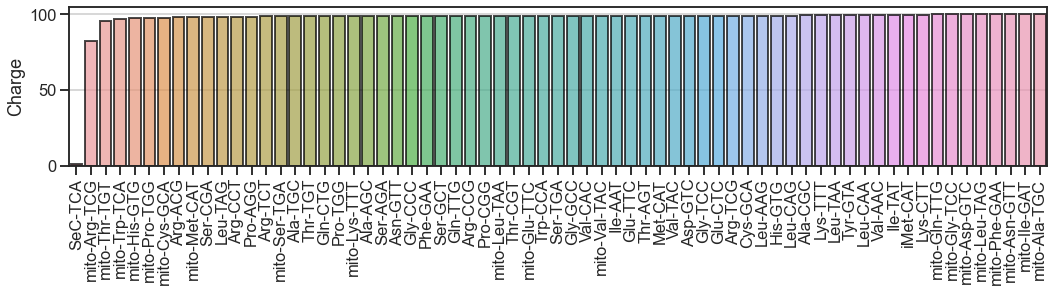

In [244]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 4.4))

g1 = sns.barplot(ax=ax1, x='Codon', y='Charge', data=df[mask].sort_values('Charge'), capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.grid(True, axis='y')
g1.set_ylabel('Charge');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)



plt.tight_layout()
#fig.savefig('influx.pdf')

In [205]:
codon_list = [
'Asp-GTC',
'mito-Asp-GTC',
'Leu-AAG',
'Leu-CAA',
'Leu-CAG',
'Leu-TAA',
'Leu-TAG',
'mito-Leu-TAA',
'mito-Leu-TAG',
'Arg-ACG',
'Arg-CCG',
'Arg-CCT',
'Arg-TCG',
'Arg-TCT',
'mito-Arg-TCG'
]
mask = (df['Replicate'] == 'NaCl') & ((df['CCA_count'] + df['CC_count']) > 60) & (df['Charge'] > 0) & (df['Codon'].isin(codon_list))

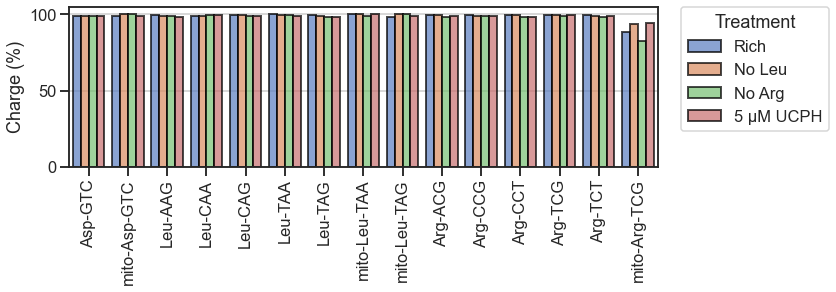

In [206]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4.4))

g1 = sns.barplot(ax=ax1, x='Codon', y='Charge', hue='Condition', order=codon_list, hue_order=['Rich', 'L', 'A', 'U'], data=df[mask].sort_values('Charge'), capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['Rich', 'No Leu', 'No Arg', '5 μM UCPH']
title = 'Treatment'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)


plt.tight_layout()
fig.savefig('tRNA_charge_NaCl.pdf')

In [225]:
charge_norm = list()
for idx in df.index:
    entry = df.loc[idx]
    codon = entry.Codon
    cond = entry.Condition
    
    nacl_mask = (df['Codon'] == codon) & (df['Condition'] == cond) & (df['Replicate'] == 'NaCl')
    if len(df[nacl_mask]) > 0 and df[nacl_mask]['Charge'].values[0] > 0:
        nacl_charge = df[nacl_mask]['Charge'].values[0]
        charge_norm.append(entry.Charge / nacl_charge * 100)
    else:
        charge_norm.append(entry.Charge)

In [227]:
df['Charge_norm'] = charge_norm

In [228]:
codon_list = [
'Asp-GTC',
'mito-Asp-GTC',
'Leu-AAG',
'Leu-CAA',
'Leu-CAG',
'Leu-TAA',
'Leu-TAG',
'mito-Leu-TAA',
'mito-Leu-TAG',
'Arg-ACG',
'Arg-CCG',
'Arg-CCT',
'Arg-TCG',
'Arg-TCT',
'mito-Arg-TCG'
]
mask = (df['Replicate'] != 'NaCl') & ((df['CCA_count'] + df['CC_count']) > 60) & (df['Charge'] > 0) & (df['Codon'].isin(codon_list))

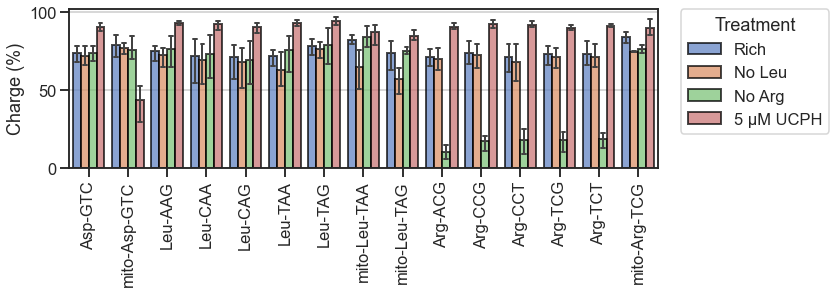

In [229]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4.4))

g1 = sns.barplot(ax=ax1, x='Codon', y='Charge_norm', hue='Condition', order=codon_list, hue_order=['Rich', 'L', 'A', 'U'], data=df[mask].sort_values('Charge'), capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.grid(True, axis='y')
g1.set_ylabel('Charge (%)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = ['Rich', 'No Leu', 'No Arg', '5 μM UCPH']
title = 'Treatment'
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04,1), borderaxespad=0)


plt.tight_layout()
fig.savefig('tRNA_charge_norm.pdf')

In [110]:
sample = 'A-1'
CCA_dict[sample]['mito-Asp-GTC']['CCA'] / (CCA_dict[sample]['mito-Asp-GTC']['CCA'] + CCA_dict[sample]['mito-Asp-GTC']['CC'])

0.7014925373134329

In [111]:
sample = 'A-1'
CCA_dict[sample]['Asp-GTC']['CCA'] / (CCA_dict[sample]['Asp-GTC']['CCA'] + CCA_dict[sample]['Asp-GTC']['CC'])

0.682315112540193

In [122]:
CCA_dict

{'U-2': defaultdict(dict,
             {'Gly-TCC': {'CC': 119, 'CCA': 1330},
              'Phe-GAA': {'CC': 81, 'CCA': 992},
              'Asp-GTC': {'CC': 124, 'CCA': 1518},
              'Ala-AGC': {'CC': 166, 'CCA': 1560},
              'Ala-CGC': {'CC': 89, 'CCA': 1041},
              'Glu-TTC': {'CC': 99, 'CCA': 1006},
              'Gly-GCC': {'CC': 129, 'CCA': 1407},
              'His-GTG': {'CC': 390, 'CCA': 967},
              'Thr-AGT': {'CC': 534, 'CCA': 990},
              'mito-Phe-GAA': {'CC': 21, 'CCA': 92},
              'Val-AAC': {'CC': 39, 'CCA': 1006},
              'Val-TAC': {'CC': 20, 'CCA': 377},
              'Met-CAT': {'CC': 123, 'CCA': 1008},
              'Pro-TGG': {'CC': 105, 'CCA': 596},
              'Arg-TCG': {'CC': 63, 'CCA': 700},
              'Glu-CTC': {'CC': 147, 'CCA': 2081},
              'iMet-CAT': {'CC': 99, 'CCA': 1328},
              'Thr-TGT': {'CC': 140, 'CCA': 567},
              'Trp-CCA': {'CC': 43, 'CCA': 835},
              'Leu